In [2]:
import numpy as np
import healpy as hp
import camb
import matplotlib.pyplot as plt
import astropy.io.fits as fits


In [3]:
nside = 512 #64
npix = 12*nside**2
lmax = 2*nside #120

In [4]:

def generate_power_spectra_CAMB(Nside,  r=10**(-2), H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06, ns=0.965, lens_potential_accuracy=1, nt=0, ntrun=0, lmax_f=0, type_power='total', typeless_bool=False):
    """
    Return [Cl^TT, Cl^BB, Cl^EE, Cl^TE]
    """
    lmax_ = 3*Nside-1
    if lmax_f !=0:
        lmax_ = lmax_f
    
    pars = camb.CAMBparams(max_l_tensor=lmax_, parameterization='tensor_param_indeptilt')
    pars.WantTensors = True

    pars.Accuracy.AccurateBB = True
    pars.Accuracy.AccuratePolarization = True
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, mnu=mnu, omk=omk, tau=tau)
    pars.InitPower.set_params(As=2e-9, ns=ns, r=r, parameterization='tensor_param_indeptilt', nt=nt, ntrun=ntrun)
    pars.max_eta_k_tensor = lmax_ + int(lmax_/15) # 100  # 15000  # 100

    # pars.set_cosmology(H0=H0)
    pars.set_for_lmax(lmax_, lens_potential_accuracy=lens_potential_accuracy)

    print("Calculating spectra from CAMB !")
    results = camb.get_results(pars)

    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True, lmax=lmax_)    
    if typeless_bool:
        return powers
    return powers[type_power]


In [5]:
def generate_HP_Map_0(Nside, CL_total, l_min=0, lmax=1536, pixwin=True, fwhm=0):
    CL_list = [CL_total[l_min:lmax,0], CL_total[l_min:lmax,3], CL_total[l_min:lmax,1], CL_total[l_min:lmax,2]]
    return hp.sphtfunc.synfast(CL_list, Nside, lmax=lmax, pixwin=pixwin, fwhm=fwhm)


In [6]:
c_l_total = generate_power_spectra_CAMB(nside, lmax_f=lmax)

Calculating spectra from CAMB !


In [7]:
c_l_total.shape

(1025, 4)

/global/homes/m/mag/.conda/envs/ttpy37/lib/python3.7/site-packages/healpy/sphtfunc.py:438: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,
/global/homes/m/mag/.conda/envs/ttpy37/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/global/homes/m/mag/.conda/envs/ttpy37/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/global/homes/m/mag/.conda/envs/ttpy37/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. 

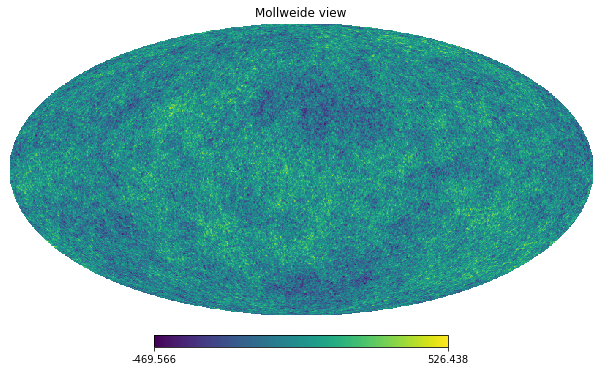

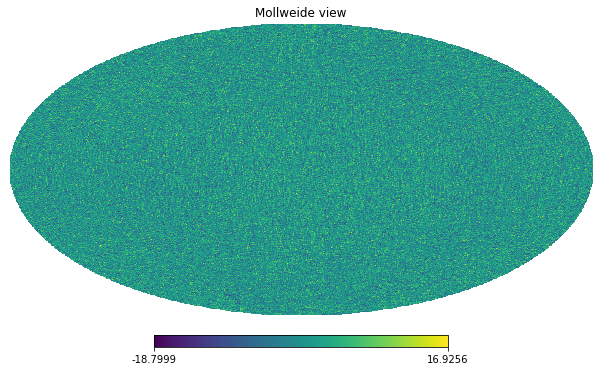

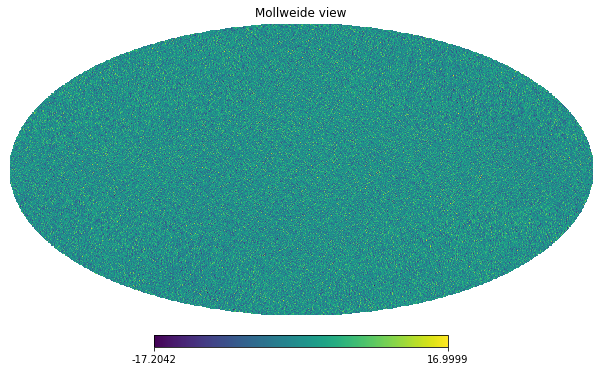

In [8]:
Map_HP = generate_HP_Map_0(nside, c_l_total, pixwin=False, lmax=lmax)#, fwhm=50*np.pi/180)

hp.mollview(Map_HP[0])
hp.mollview(Map_HP[1])
hp.mollview(Map_HP[2])

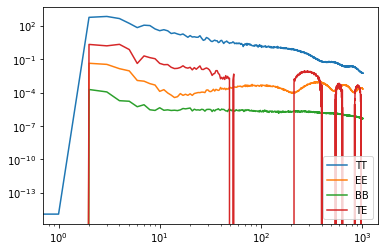

In [9]:
lmax_plot = c_l_total.shape[0]-1

plt.figure()
plt.plot(np.arange(lmax_plot), hp.anafast(Map_HP, lmax=lmax-1).T[:,:4])
plt.loglog()
plt.legend(['TT', 'EE', 'BB', 'TE'])
plt.show()

In [10]:
def save_map_Xpure_from_maps(maps_TQU, directory_path='', outname=''):
    """ maps_TQU must have the dimension (3, 12*nside**2)
    """

    print('Shape maps TQU', maps_TQU.shape)
    print('Recording 3-maps in', directory_path, outname)
    map_names = ['T', 'Q', 'U']
    if directory_path=='':
        raise Exception('NO DIRECTORY PATH TO SAVE !!!')
        return
    list_hdu = [fits.PrimaryHDU(maps_TQU)]
    list_hdu.append(fits.BinTableHDU.from_columns([fits.Column(name=map_names[i], array=maps_TQU[i,:], format='1D') for i in range(3)]))

    hdu_list = fits.HDUList(list_hdu)
    Header = fits.Header()
    # Header['ORDERING'] = 'RING'
    # Header['SIMPLE'] = 'T'
    # Header['BITPIX'] = -64
    # Header['NAXIS'] = 2
    # Header['NAXIS1']  = 204
    # Header['EXTEND']  = 'T'
    # Header['NAXIS2'] = 204
    # fits.writeto(directory_path+'bin_5_1024.fits', ell_NaMs[ell_NaMs<lmax], header=Header)
    # hdu_list.writeto(directory_path+'map_TQU_35f_4.fits')
    # hdu_list.writeto(directory_path+outname+'.fits', header=Header)
    endfile = ''
    if outname[-5:] != '.fits':
        endfile = '.fits'
    hdu_list.writeto(directory_path+outname+endfile,overwrite=True)


In [11]:
directory_path = '/global/cscratch1/sd/mag/xPure_data/Files_Launch/'
# outname = 'Map_band_limited_1_degree'
outname = 'Map_band_limited_1_degree_bis'

# save_map_Xpure_from_maps(Map_HP, directory_path=directory_path, outname=outname)


In [20]:
path_map_WF = "/global/cscratch1/sd/mag/WF_work/WF_Tests/mapfile_{}_{}.fits"

Map_HP_init = np.zeros((3,npix))
Map_HP_1 = np.zeros((3,npix))

for i in range(3):
    Map_HP_1[i] = hp.read_map(path_map_WF.format('2', i))
    Map_HP_init[i] = hp.read_map(path_map_WF.format('init', i))

/global/homes/m/mag/.conda/envs/ttpy37/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/global/homes/m/mag/.conda/envs/ttpy37/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 512
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/m/mag/.conda/envs/ttpy37/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/m/mag/.conda/envs/ttpy37/lib/python3.7/site-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in head

/global/homes/m/mag/.conda/envs/ttpy37/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/m/mag/.conda/envs/ttpy37/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/global/homes/m/mag/.conda/envs/ttpy37/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In

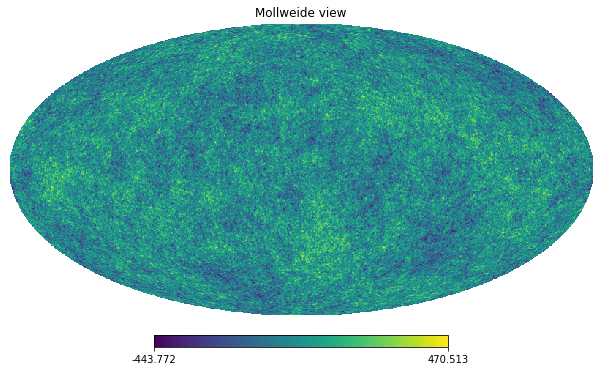

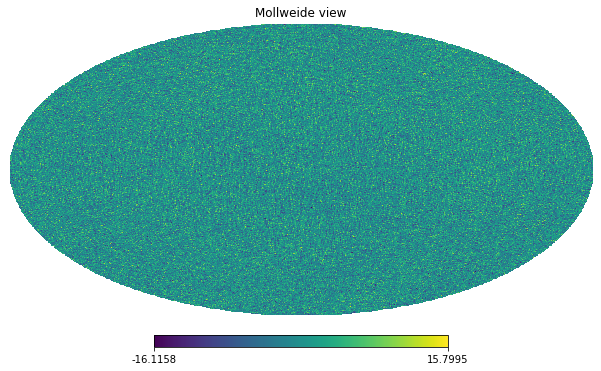

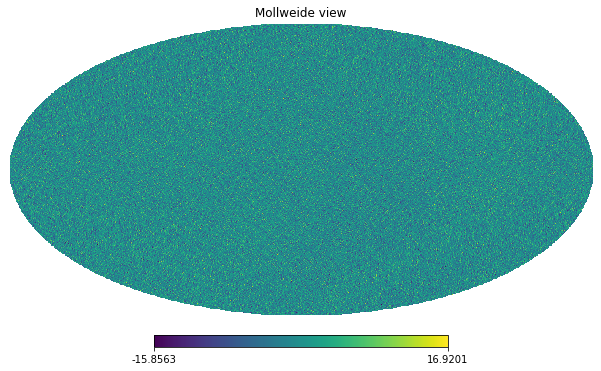

In [21]:
hp.mollview(Map_HP_1[0])
hp.mollview(Map_HP_1[1])
hp.mollview(Map_HP_1[2])

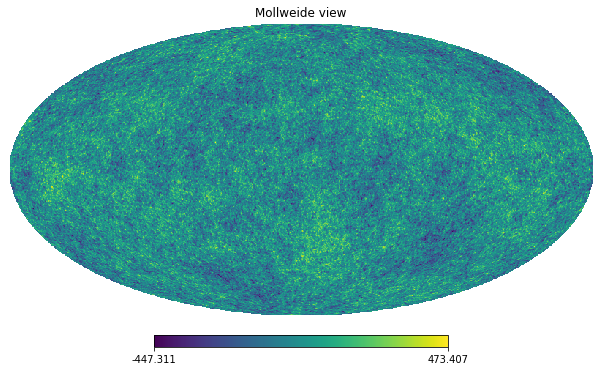

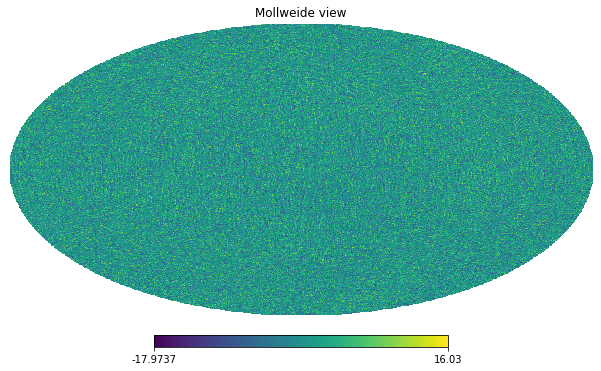

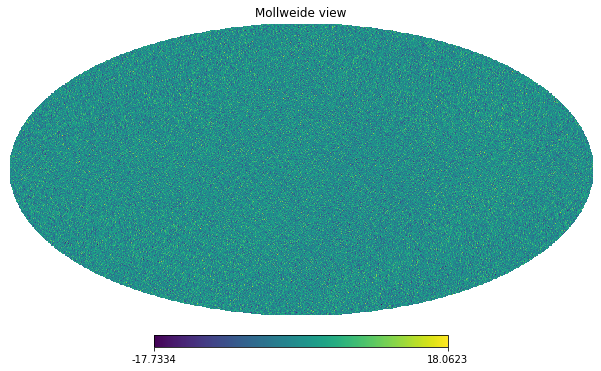

In [22]:

hp.mollview(Map_HP_init[0])
hp.mollview(Map_HP_init[1])
hp.mollview(Map_HP_init[2])

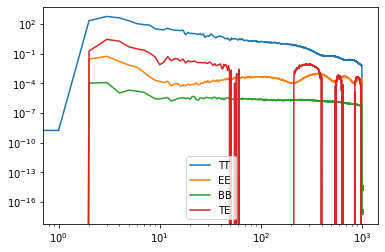

In [23]:
lmax_plot = c_l_total.shape[0]-1

plt.figure()
plt.plot(np.arange(lmax_plot), hp.anafast(Map_HP_1, lmax=lmax-1).T[:,:4])
plt.loglog()
plt.legend(['TT', 'EE', 'BB', 'TE'])
plt.show()

In [29]:
for i in range(3):
    print("Avg {} :".format("IQU"[i]),  np.mean(np.abs((Map_HP[i]-Map_HP_1[i])/Map_HP_1[i])))
    print("Std {} :".format("IQU"[i]),  np.std(np.abs((Map_HP[i]-Map_HP_1[i])/Map_HP_1[i])))
    print("Max {} :".format("IQU"[i]),  np.max(np.abs((Map_HP[i]-Map_HP_1[i])/Map_HP_1[i])))
    


Avg I : 11.004902813049853
Std I : 2450.066950297914
Max I : 3843839.630706334
Avg Q : 11.456148315707553
Std Q : 2486.875400290894
Max Q : 3537014.5572854253
Avg U : 26.60996413049411
Std U : 27224.581778559485
Max U : 48097628.71367931


/global/homes/m/mag/.conda/envs/ttpy37/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/m/mag/.conda/envs/ttpy37/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/global/homes/m/mag/.conda/envs/ttpy37/lib/python3.7/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In

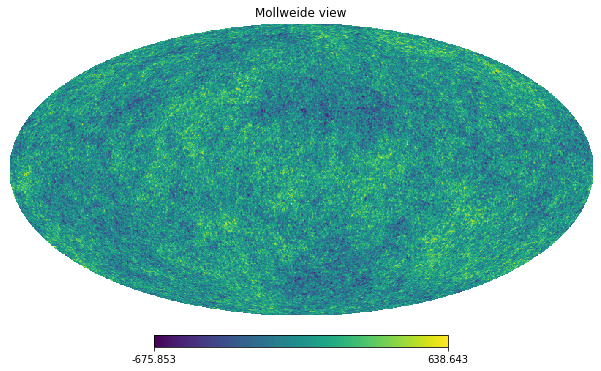

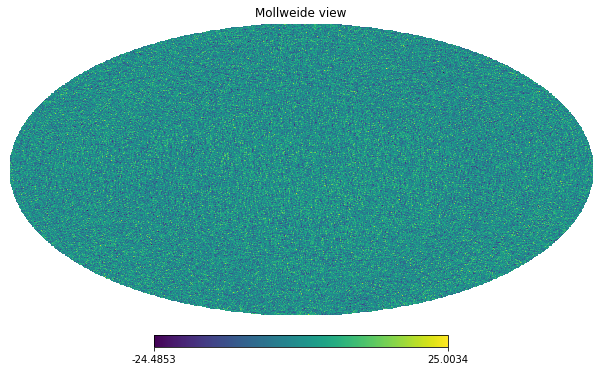

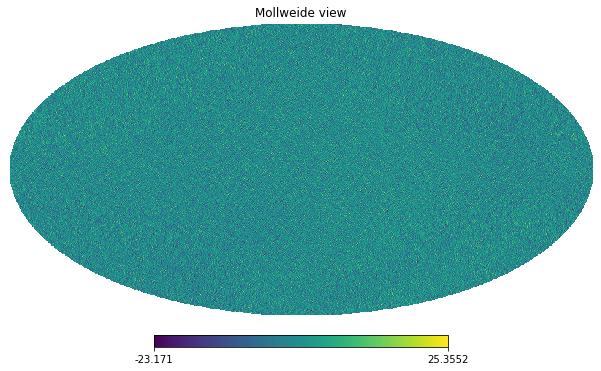

In [25]:

hp.mollview(Map_HP[0] - Map_HP_1[0])
hp.mollview(Map_HP[1] - Map_HP_1[1])
hp.mollview(Map_HP[2] - Map_HP_1[2])

In [26]:
lmax_plot = c_l_total.shape[0]-1

C_ell_init_0 =  hp.anafast(Map_HP, lmax=lmax-1)
C_ell_init_1 =  hp.anafast(Map_HP_init, lmax=lmax-1)
C_ell_1 =  hp.anafast(Map_HP_1, lmax=lmax-1)


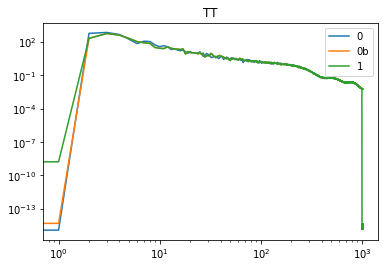

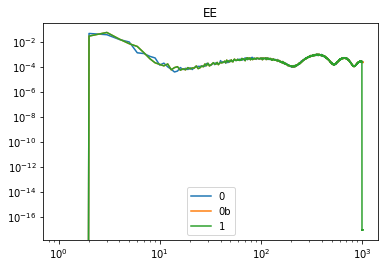

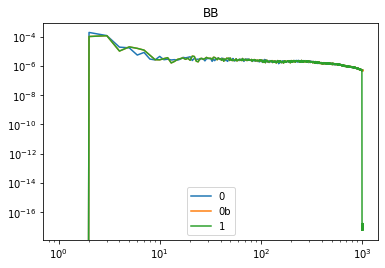

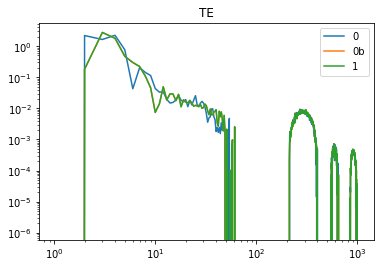

In [27]:

dic_correl = ['TT', 'EE', 'BB', 'TE']
for i in range(4):
    plt.figure()
    plt.plot(np.arange(lmax_plot), C_ell_init_0[i], label='0')
    plt.plot(np.arange(lmax_plot), C_ell_init_1[i], label='0b')
    plt.plot(np.arange(lmax_plot), C_ell_1[i], label='1')
    plt.loglog()
    plt.legend()
    plt.title("{}".format(dic_correl[i]))
plt.show()

In [ ]:
# path_map_WF_test_ring_nest = "/global/cscratch1/sd/mag/WF_work/WF_Tests/mapfile_test_ring.fits"

# Map_HP_nest = hp.read_map()